In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-28 16:11:03 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-28 16:11:03 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-28 16:11:03 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-28 16:11:07 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-28 16:11:07 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-28 16:11:07 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-28 16:11:07 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-28 16:11:08 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-28 16:11:08 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-28 16:11:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-28 16:11:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-28 16:11:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-28 16:11:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-28 16:11:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-28 16:11:58 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

select_task.filter_single_token(tokenizer=mt.tokenizer, prefix=" ")

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(11), vehicle(8), furniture(8), animal(13), music instrument(3), clothing(11), electronics(11), sport equipment(5), kitchen appliance(4), vegetable(5), building(14), office supply(8), bathroom item(7), flower(6), tree(10), jewelry(7)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Apple -> Orange (2): ['Mirror', 'Blender', 'Orange', 'Monitor', 'Cabinet', 'Oak']
Options: Mirror, Blender, Orange, Monitor, Cabinet, Oak.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Mirror, Blender, Orange, Monitor, Cabinet, Oak.
Which among these objects mentioned above is a fruit?
Answer:" >> Orange


(True,
 [PredictedToken(token=' Orange', prob=0.81640625, logit=21.875, token_id=22725, metadata=None),
  PredictedToken(token=' The', prob=0.07568359375, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.035888671875, logit=18.75, token_id=22395, metadata=None),
  PredictedToken(token=' An', prob=0.0279541015625, logit=18.5, token_id=1556, metadata=None),
  PredictedToken(token=' orange', prob=0.0054931640625, logit=16.875, token_id=19087, metadata=None)],
 OrderedDict([(22725,
               (1,
                PredictedToken(token=' Orange', prob=0.81640625, logit=21.875, token_id=22725, metadata=None))),
              (18787,
               (28,
                PredictedToken(token=' Oak', prob=0.0003299713134765625, logit=14.0625, token_id=18787, metadata=None))),
              (88668,
               (31,
                PredictedToken(token=' Blender', prob=0.0002918243408203125, logit=13.9375, token_id=88668, metadata=None))),
              (34954

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Orange.
Explanation: Orange is a fruit. The other options are not fruits. Mirror, Blender," >> Orange


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


2025-08-28 16:12:10 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-28 16:12:10 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-28 16:12:10 matplotlib DEBUG    interactive is False
2025-08-28 16:12:10 matplotlib DEBUG    platform is linux
2025-08-28 16:12:10 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-28 16:12:10 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-28 16:12:11 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-28 16:12:11 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-28 16:12:11 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-28 16:12:11 matplotlib.font

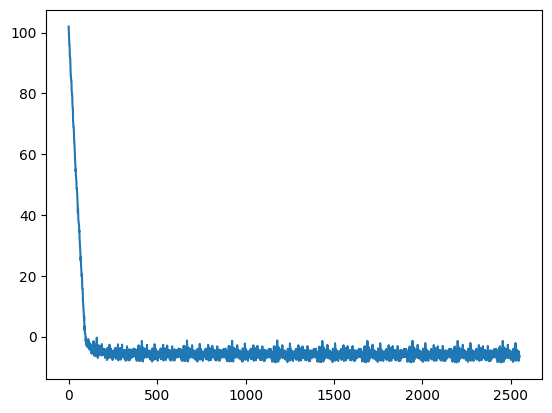

In [12]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

80


(True, True)

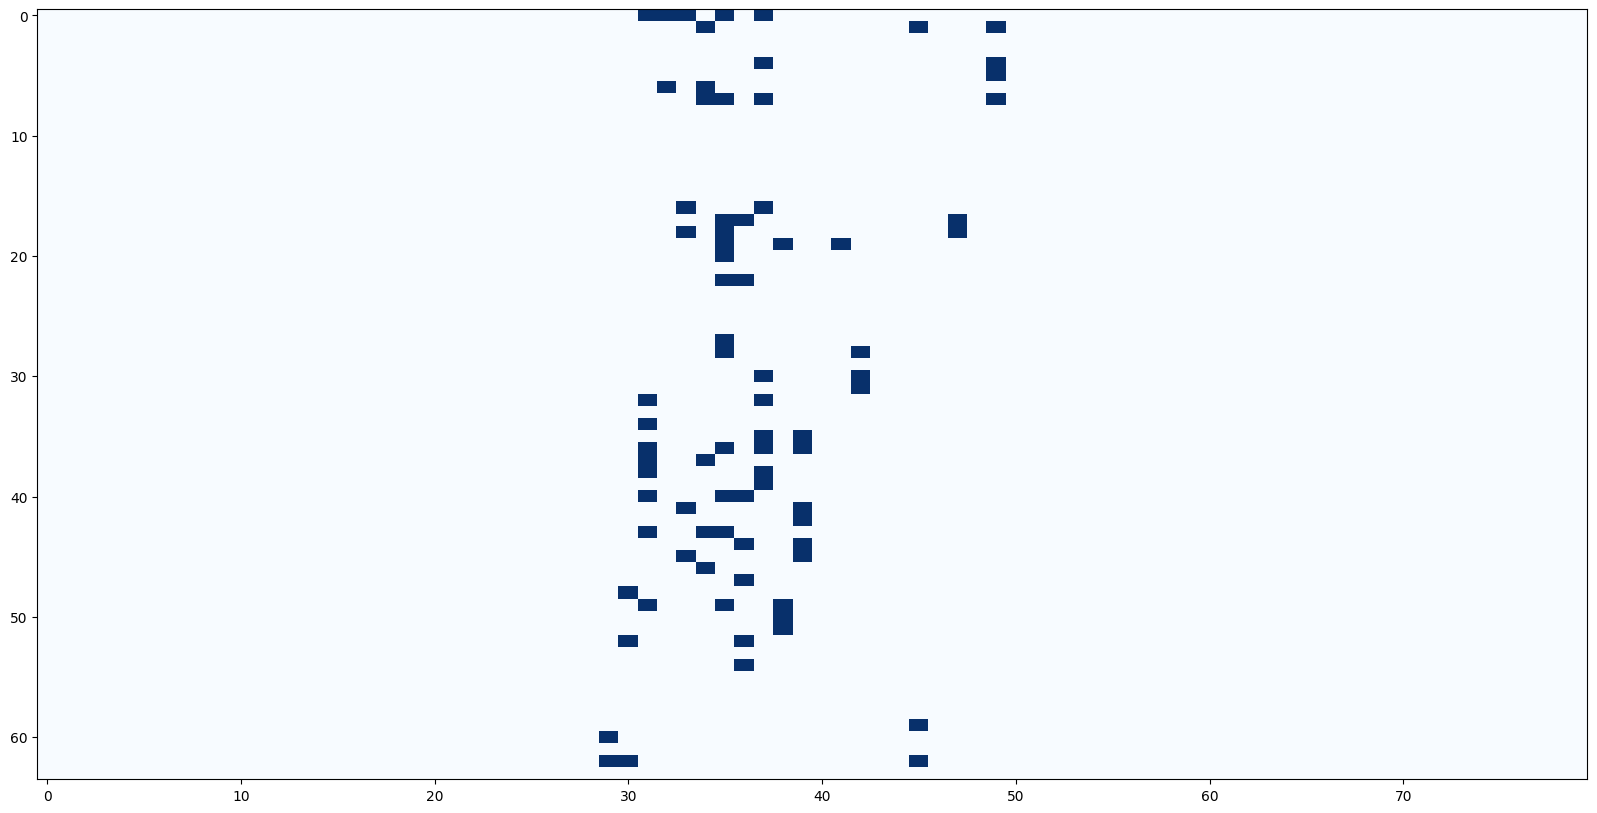

In [13]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [14]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

0 patches to ablate possible answer information from options
2025-08-28 16:12:15 src.selection.functional DEBUG    Predictions: ['" Orange"[22725] (p=0.816, logit=21.875)', '" The"[578] (p=0.076, logit=19.500)', '" Among"[22395] (p=0.036, logit=18.750)', '" An"[1556] (p=0.028, logit=18.500)', '" orange"[19087] (p=0.005, logit=16.875)']
2025-08-28 16:12:15 src.selection.functional INFO     Combined attention matrix for all heads


In [15]:
from src.functional import generate_with_patch
mt.reset_forward()
mt.set_attn_implementation("eager")

sample_cat_1 = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=4,
    category="fruit",
    filter_by_lm_prediction=False,
)

sample_cat_2 = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    category="vehicle",
    filter_by_lm_prediction=False,
)

for sample in [sample_cat_1, sample_cat_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Basketball, Shower, Apartment, Suit, Pear, Printer.
Which among these objects mentioned above is a fruit?
Answer: >> Pear
0 patches to ablate possible answer information from options
2025-08-28 16:12:15 src.selection.functional DEBUG    Predictions: ['" Pear"[23910] (p=0.836, logit=22.375)', '" The"[578] (p=0.069, logit=19.875)', '" A"[362] (p=0.037, logit=19.250)', '" Among"[22395] (p=0.032, logit=19.125)', '" pear"[38790] (p=0.003, logit=16.750)']
2025-08-28 16:12:15 src.selection.functional INFO     Combined attention matrix for all heads


Options: Monitor, Helmet, Truck, Guitar, Shirt, Dog.
Which among these objects mentioned above is a vehicle?
Answer: >> Truck
0 patches to ablate possible answer information from options
2025-08-28 16:12:16 src.selection.functional DEBUG    Predictions: ['" Truck"[34785] (p=0.613, logit=21.750)', '" The"[578] (p=0.176, logit=20.500)', '" A"[362] (p=0.083, logit=19.750)', '" Among"[22395] (p=0.083, logit=19.750)', '" It"[1102] (p=0.005, logit=17.000)']
2025-08-28 16:12:16 src.selection.functional INFO     Combined attention matrix for all heads


In [16]:
from src.selection.functional import cache_q_projections
from src.utils.typing import TokenizerOutput
from src.tokens import prepare_input, find_token_range

cat1_tokenized = prepare_input(prompts=sample_cat_1.prompt(), tokenizer=mt.tokenizer)
cat2_tokenized = prepare_input(prompts=sample_cat_2.prompt(), tokenizer=mt.tokenizer)

query_indices = {-3: -3, -2: -2, -1:-1}
query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in HEADS
    # for layer_idx, head_idx in [(35, 19)]
    for patch_query_idx in query_indices.keys()
]

query_states_1 = cache_q_projections(
    mt=mt,
    input=cat1_tokenized,
    query_locations=query_locations,
)

query_states_2 = cache_q_projections(
    mt=mt,
    input=cat2_tokenized,
    query_locations=query_locations,
)

In [20]:
from src.selection.data import SelectionSample

# options = ["Deer", "Book", "Plane", "Bottle"]
options = ["Deer", "Book", "Apple", "Bottle", "Comb"]

gold_prompt = f"""Options: {', '.join(options)}.
Which one in the list is a fruit or a vehicle?
Answer:"""

gold_attn_pattern = verify_head_patterns(
    prompt=gold_prompt,
    mt=mt,
    heads=HEADS,
    # heads=[(35, 19)],
    # generate_full_answer=True,
    query_index=-1
)

clean_prompt = f"""Options: {', '.join(options)}
Which one in the list is an animal?
Answer:"""

clean_attn_pattern = verify_head_patterns(
    prompt=clean_prompt,
    mt=mt,
    heads=HEADS,
    # heads=[(35, 19)],
    # generate_full_answer=True,
    query_index=-1
)

0 patches to ablate possible answer information from options
2025-08-28 16:13:04 src.selection.functional DEBUG    Predictions: ['" Apple"[8325] (p=0.715, logit=20.750)', '" An"[1556] (p=0.097, logit=18.750)', '" The"[578] (p=0.059, logit=18.250)', '" None"[2290] (p=0.046, logit=18.000)', '" There"[2684] (p=0.012, logit=16.625)']
2025-08-28 16:13:04 src.selection.functional INFO     Combined attention matrix for all heads


0 patches to ablate possible answer information from options
2025-08-28 16:13:04 src.selection.functional DEBUG    Predictions: ['" Deer"[64191] (p=0.871, logit=22.625)', '" The"[578] (p=0.056, logit=19.875)', '" A"[362] (p=0.049, logit=19.750)', '" DE"[3467] (p=0.009, logit=18.000)', '" D"[423] (p=0.002, logit=16.750)']
2025-08-28 16:13:04 src.selection.functional INFO     Combined attention matrix for all heads


In [21]:
from src.functional import PatchSpec

for query_states in [query_states_1, query_states_2]:
    q_proj_patches = []
    for (layer_idx, head_idx, query_idx), q_proj in query_states.items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=q_proj,
            )
        )

    verify_head_patterns(
        prompt=clean_prompt,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1,
        query_patches=q_proj_patches
    )

240 patches to ablate possible answer information from options
2025-08-28 16:13:12 src.selection.functional DEBUG    Predictions: ['" Apple"[8325] (p=0.684, logit=22.125)', '" The"[578] (p=0.135, logit=20.500)', '" An"[1556] (p=0.135, logit=20.500)', '" APPLE"[91436] (p=0.016, logit=18.375)', '" an"[459] (p=0.002, logit=16.500)']
2025-08-28 16:13:12 src.selection.functional INFO     Combined attention matrix for all heads


240 patches to ablate possible answer information from options
2025-08-28 16:13:12 src.selection.functional DEBUG    Predictions: ['" Bottle"[55085] (p=0.832, logit=21.750)', '" The"[578] (p=0.099, logit=19.625)', '" A"[362] (p=0.020, logit=18.000)', '" B"[426] (p=0.012, logit=17.500)', '" An"[1556] (p=0.006, logit=16.875)']
2025-08-28 16:13:12 src.selection.functional INFO     Combined attention matrix for all heads


In [22]:
combined_q_proj_patches = []

for layer_idx, head_idx, query_idx in query_states_1:
    proj = (
        query_states_1[(layer_idx, head_idx, query_idx)]
        + query_states_2[(layer_idx, head_idx, query_idx)]
    )
    combined_q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch=proj,
        )
    )

verify_head_patterns(
    prompt=clean_prompt,
    mt=mt,
    heads=HEADS,
    # heads=[(35, 19)],
    # generate_full_answer=True,
    query_index=-1,
    query_patches=combined_q_proj_patches,
)

240 patches to ablate possible answer information from options


2025-08-28 16:13:12 src.selection.functional DEBUG    Predictions: ['" Apple"[8325] (p=0.660, logit=21.125)', '" The"[578] (p=0.147, logit=19.625)', '" An"[1556] (p=0.089, logit=19.125)', '" Bottle"[55085] (p=0.014, logit=17.250)', '" A"[362] (p=0.014, logit=17.250)']
2025-08-28 16:13:12 src.selection.functional INFO     Combined attention matrix for all heads


{'predictions': [PredictedToken(token=' Apple', prob=0.66015625, logit=21.125, token_id=8325, metadata=None),
  PredictedToken(token=' The', prob=0.1474609375, logit=19.625, token_id=578, metadata=None),
  PredictedToken(token=' An', prob=0.08935546875, logit=19.125, token_id=1556, metadata=None),
  PredictedToken(token=' Bottle', prob=0.01373291015625, logit=17.25, token_id=55085, metadata=None),
  PredictedToken(token=' A', prob=0.01373291015625, logit=17.25, token_id=362, metadata=None)],
 'logits': tensor([0.5391, 2.4531, 4.1250,  ..., 0.1455, 0.1455, 0.1455],
        dtype=torch.bfloat16),
 'attn_matrices': AttentionInformation(tokenized_prompt=['<|begin_of_text|>', 'Options', ':', ' Deer', ',', ' Book', ',', ' Apple', ',', ' Bottle', ',', ' Comb', '\n', 'Which', ' one', ' in', ' the', ' list', ' is', ' an', ' animal', '?\n', 'Answer', ':'], attention_matrices=array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],

## Scale Up